# 複数のQRコードからCSVへ復元する

* csv→圧縮→base64→分割（ヘッダ付加）→QR画像
  ⇒ タイル状に連結されている
* QR連結画像からデコードして
  → 分割されたbase64 →バイナリ →連結 →解凍
  して CSV に戻す
  * 付加されているヘッダ（総数、順番号）をもとに、
    一旦辞書に格納したバイナリを、
    正しい順序で連結して書庫に戻す
  * 解凍してCSVに戻す
* オリジナルのCSVと比較





In [1]:
# ライブラリをインストール
!sudo apt install libzbar0
!pip install pyzbar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libv4l-0 libv4lconvert0
The following NEW packages will be installed:
  libv4l-0 libv4lconvert0 libzbar0
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 238 kB of archives.
After this operation, 817 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libv4lconvert0 amd64 1.18.0-2build1 [76.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libv4l-0 amd64 1.18.0-2build1 [41.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libzbar0 amd64 0.23-1.3 [119 kB]
Fetched 238 kB in 0s (570 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling back to frontend: Readline

In [2]:
# 事前に Google Drive へ接続しておく
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ライブラリ読み込み
import sys
import os
import subprocess
from PIL import Image
from IPython.display import Image as disp_Image
from IPython.display import display_png
from pyzbar.pyzbar import decode, ZBarSymbol
import cv2
import numpy as np
import copy
import base64

In [4]:
# 作業ディレクトリ
work_dir = "/content/drive/MyDrive/QRコード操作"

/content/drive/MyDrive/QRコード操作/qr.tile.gm.gif
size: 10,797 Byte(10.54 KB)


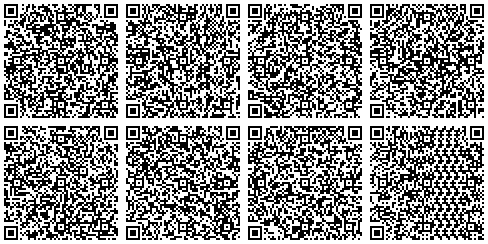

In [27]:
# 対象QR画像
#qr_tile = os.path.join(work_dir, "qr.tile.png")
qr_tile = os.path.join(work_dir, "qr.tile.gm.gif")
print(qr_tile)
s = os.path.getsize(qr_tile)
sk = s / 1024
print("size: {0:,} Byte({1:.2f} KB)".format(s, sk))
display(disp_Image(qr_tile))

In [56]:
# OpenCVで読み込む場合
# GIFには対応していないのであらかじめPNGなどに変換しておく必要がある
gif = Image.open(qr_tile)
png = os.path.join(work_dir, "qr.tile.png")
gif.save(png)
img_tile = cv2.imread(png) 

In [57]:
# PyZBarでデコードする
# PyZBarタイル状のQRをデコードする
# ちなみに PyZBar の decode は Pillow 形式でもデコード可能だが、
# あとの処理で検出エッジラインをOpenCVで描画する都合上、
# ↑のように一旦PNGなどにしてOpenCVで読み込んで置く
decoded_list = decode(img_tile, symbols=[ZBarSymbol.QRCODE])
print(f'{len(decoded_list)} QR code detected.')

8 QR code detected.


In [58]:
# 一時格納用辞書
decoded_data = {}

In [59]:
# デコードされたデータを辞書に貯めつつ、検出エッジを描画する
total_size = 0
for qr in decoded_list:
  if qr == '':
      continue
  b64 = qr.data
  print(f'decoded base64 data: {b64}')
  # バイナリに戻す
  d = base64.b64decode(b64)
  print(f'decoded header and bin data: {d}')
  # ヘッダを分離して順番号をキーにして辞書に貯める
  maxseq = d[0]
  seq = d[1]
  print(f'seq/max: {seq}/{maxseq}')
  data = d[2:]
  print(f'decoded bin data({seq}/{maxseq}): {data}')
  decoded_data[seq] = data
  total_size += len(data)
print(f'{len(decoded_data)} QR code decoded.')
print(f'total size: {total_size} bytes.')

decoded base64 data: b'CAgAIICAgQAA'
decoded header and bin data: b'\x08\x08\x00 \x80\x80\x81\x00\x00'
seq/max: 8/8
decoded bin data(8/8): b'\x00 \x80\x80\x81\x00\x00'
decoded base64 data: b'CAfu0mUFsLyRL91soKZNdYdJ+AiKi1i/lkcVYhg3hSrl58mKukael51LKTqsBI+/2KnEegEEBgABCYPAAAcLAQACJAbxBwEKUwfPHZiRKLG6AiMDAQEFXQAYAAABAAyDtZK8AAgKAd0onWcAAAUBGQARGQBtAGUAaQBzAGEAaQAyAC4AYwBzAHYAAAAZAgAAFAoBAADkQ5t4hNkBFQYB'
decoded header and bin data: b'\x08\x07\xee\xd2e\x05\xb0\xbc\x91/\xddl\xa0\xa6Mu\x87I\xf8\x08\x8a\x8bX\xbf\x96G\x15b\x187\x85*\xe5\xe7\xc9\x8a\xbaF\x9e\x97\x9dK):\xac\x04\x8f\xbf\xd8\xa9\xc4z\x01\x04\x06\x00\x01\t\x83\xc0\x00\x07\x0b\x01\x00\x02$\x06\xf1\x07\x01\nS\x07\xcf\x1d\x98\x91(\xb1\xba\x02#\x03\x01\x01\x05]\x00\x18\x00\x00\x01\x00\x0c\x83\xb5\x92\xbc\x00\x08\n\x01\xdd(\x9dg\x00\x00\x05\x01\x19\x00\x11\x19\x00m\x00e\x00i\x00s\x00a\x00i\x002\x00.\x00c\x00s\x00v\x00\x00\x00\x19\x02\x00\x00\x14\n\x01\x00\x00\xe4C\x9bx\x84\xd9\x01\x15\x06\x01'
seq/max: 7/8
decoded bin data(7/8): b'\xee

In [60]:
# エッジ描画用画像に複製
img_edge = copy.deepcopy(img_tile)

/content/drive/MyDrive/QRコード操作/qr.edge.png


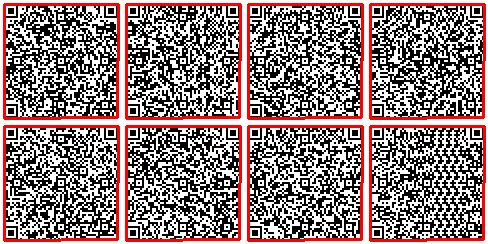

In [61]:
# デコードされたQRの検エッジを描画
for qr in decoded_list:
  if qr == '':
    continue
  pa = np.array([(p.x, p.y) for p in qr.polygon])
  cv2.polylines(img_edge, [pa], True, (0,0,255), thickness=2)

png_edge = os.path.join(work_dir, "qr.edge.png")
cv2.imwrite(png_edge, img_edge)
print(png_edge)
display_png(disp_Image(png_edge))

In [62]:
# デコードしたバイナリをソートして表示
n = len(decoded_data)
for k, b in sorted(decoded_data.items()):
  print(f'({k}/{n}): {b}')


(1/8): b"7z\xbc\xaf'\x1c\x00\x04\x90\x11\xd0d\xc0\x03\x00\x00\x00\x00\x00\x00r\x00\x00\x00\x00\x00\x00\x00<@8\x171D5`d6:\xb53|L>`\xf4\x00=\x13^\x96\xf66\xcf\xc0a\xad\xfc\xf5(\xee\xe4\xee\xc7\x80\xf1\x9a\xd5\n\xaa\xa9vx\x17^\x16a\xc0\x19k\xec,\x1b\xb7\xfc\xc2'\x952yJ\xda\xa9\x06\xb7G\xdd\xcd-\xb07\xd7r\xb3!\x19D<cGrh\xc0\xed0\xc0LU\xd4\xaa&\xe0\xfc\xbbP0_z\xef\\\xd5\xe1\x1a\xd0\xe6\x19(\xcc\xd4;\x08*tB\x14\x8d\x8f\xc3\x08zxj\xa0\xe3\xce\xdbB"
(2/8): b'\r\x82\x849\t\x0e\xbc \xa8\xedC\xae\xb1\xca\xce\xf1\x10u\xaa\x04\xc3\x87A\x13\xc0\x10T\xbb#d\x8fJ\xc0-z\xe9\n\x16^.B\x15^\xfb\xde\xfb\x158\xf6\xce\xfe\x19Dy0f\x06\xd9\x04\xea\xab\xff\xfb\x86\xe4\x02\\\xb9H\xea\x97\xd06\x04\x81ho\xebE\xccz\xe6(\x11\x85r\xf5]\xeb\x8c\xc56\xb9[]7\rs\'\x10\\\xec\xb3\xb4D\xd6.1\x99\x8f\xaa\xaa\xdfm\xf2\xf4\x97qOdY\xa6(2\x99\xff,\xdbG}u\xab>a\xc3\xd9QEj\xc2\xeeQ,\xb5"\xfcs\xdf\xbeQ\x0c\xa2^\x04\x8d\x12&'
(3/8): b'\x91l\xee\xaa\xc7M\xb3|u\x94+g\xeff\x032\xa0\xb2\xcf\xca(f\x97\xb3\x08\x9fh\xf5\x0bx\x8d\xb1V\xd7\xa

## base64 を挟めば正しくデコードできる
* バイナリのままQR生成コンポーネントに引き渡すと、どのタイミングか切り分けできていないが、余計なデータが付加されてしまう
  * おそらくは文字列前提のエンコード・デコード処理が入っている
* バイナリを一旦 base64 でテキストにエンコードしたのちに QR にすれば…
* QR からデコードした base64 テキストをデコードして元のバイナリに正しく戻すことができる


In [63]:
# バイナリを連結して書庫に戻す
bin_data = bytes()
for k, b in sorted(decoded_data.items()):
  bin_data = bin_data + bytes(b)

In [64]:
# 書庫として一時ファイルへ書き出す
temp_arc = os.path.join(work_dir, "temp.7z")
with open(temp_arc, "bw") as f:
  f.write(bin_data)
f.close()
s = os.path.getsize(temp_arc)
sk = s / 1024
print(temp_arc + " size: {0:,} Byte({1:.2f} KB)".format(s, sk))

/content/drive/MyDrive/QRコード操作/temp.7z size: 1,106 Byte(1.08 KB)


In [65]:
# 解凍する
opt = "-o{}".format(work_dir)
cmd = ["7za", "e", "-vv", "-p0000", "-y", opt, temp_arc]
ret = subprocess.run(cmd)
if ret:
  if ret.returncode != 0:
    print('7za fail.')
else:
    print('7za fail.')
target_file = os.path.join(work_dir, "meisai2.csv")
s = os.path.getsize(target_file)
sk = s / 1024
print(target_file + " size: {0:,} Byte({1:.2f} KB)".format(s, sk))

/content/drive/MyDrive/QRコード操作/meisai2.csv size: 4,796 Byte(4.68 KB)


In [66]:
# オリジナルと比較
org_file = os.path.join(work_dir, "meisai2", "meisai2.csv")
cmd = ["diff", "-sq", org_file, target_file]
print(cmd)
ret = subprocess.run(cmd)
if ret:
  print(ret.returncode)
else:
  print('diff error.')

['diff', '-sq', '/content/drive/MyDrive/QRコード操作/meisai2/meisai2.csv', '/content/drive/MyDrive/QRコード操作/meisai2.csv']
0
